In [1]:
# --- KHỞI TẠO ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from src.utils.path_converter import path_converter

# Cấu hình hiển thị
pd.set_option("display.float_format", lambda x: "%.3f" % x)
sns.set(style="whitegrid")

# 1. Thiết lập đường dẫn
current_dir = Path(os.getcwd())
data_dir = current_dir / "data" / "raw"

sales = pd.read_csv(path_converter("/data/raw/sales_train.csv"))
items = pd.read_csv(path_converter("/data/raw/items.csv"))
cats = pd.read_csv(path_converter("/data/raw/item_categories.csv"))

sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")
df = sales.merge(items, on="item_id", how="left").merge(
    cats, on="item_category_id", how="left"
)

print(f"Dữ liệu đã gộp thành công. Kích thước: {df.shape}")
print("5 dòng đầu tiên:")
display(df.head())

Dữ liệu đã gộp thành công. Kích thước: (2935849, 9)
5 dòng đầu tiên:


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.000,1.000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.000,1.000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.000,-1.000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.050,1.000,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.000,1.000,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


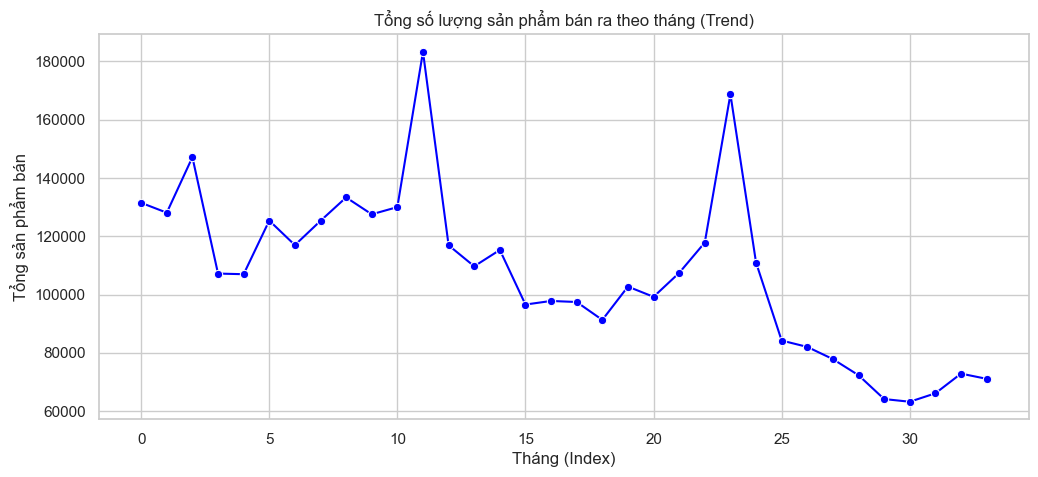

/var/folders/x8/3s0s9pbj7bgb2h7w5bbd8v7h0000gn/T/ipykernel_99702/140482584.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


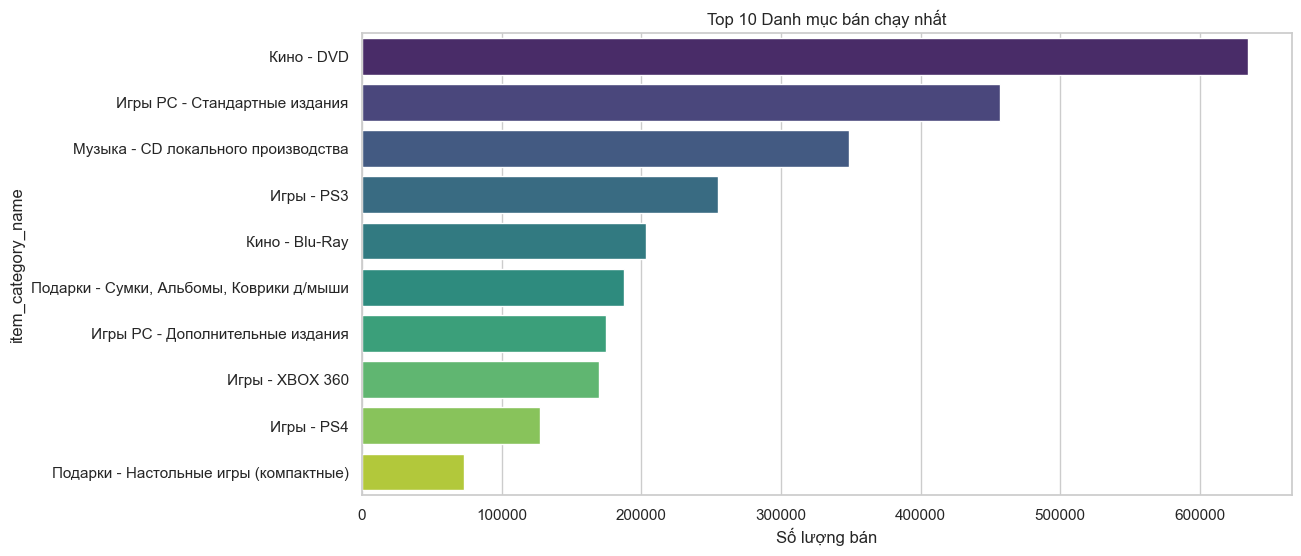

In [2]:
# --- PHÂN TÍCH XU HƯỚNG (TREND ANALYSIS) ---

# 1. Tổng doanh số theo tháng (Kiểm tra tính mùa vụ)
# date_block_num là số thứ tự tháng (0 là tháng 1/2013, 33 là tháng 10/2015)
monthly_sales = df.groupby('date_block_num')['item_cnt_day'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_sales, x='date_block_num', y='item_cnt_day', marker='o', color='blue')
plt.title('Tổng số lượng sản phẩm bán ra theo tháng (Trend)')
plt.xlabel('Tháng (Index)')
plt.ylabel('Tổng sản phẩm bán')
plt.show()

# 2. Top 10 Danh mục bán chạy nhất
top_categories = df.groupby('item_category_name')['item_cnt_day'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 10 Danh mục bán chạy nhất')
plt.xlabel('Số lượng bán')
plt.show()

>>> Kiểm tra ngoại lai (Outliers)...


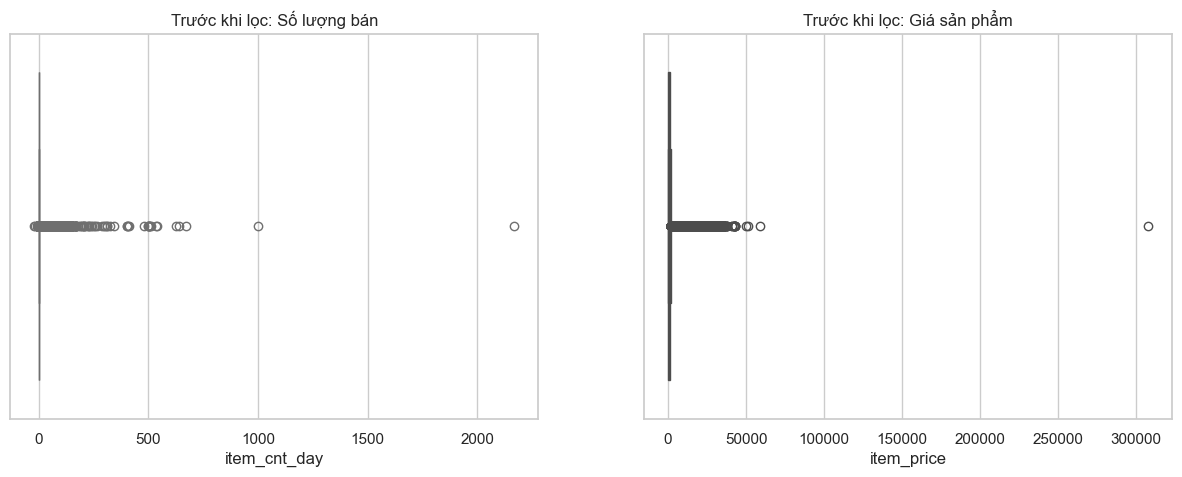

Kích thước dữ liệu gốc: (2935849, 6)
Kích thước sau khi lọc: (2935846, 6)
>>> Đã xử lý xong ngoại lai. Bắt đầu phân loại...
--- Đang tính toán ADI và CV²... ---

--- KẾT QUẢ PHÂN LOẠI (TRÊN DỮ LIỆU SẠCH) ---
Category_Type
Intermittent (Ngắt quãng)    415552
Lumpy (Khó dự báo)             8531
Erratic (Biến động)              11
Smooth (Ổn định)                  3
Name: count, dtype: int64


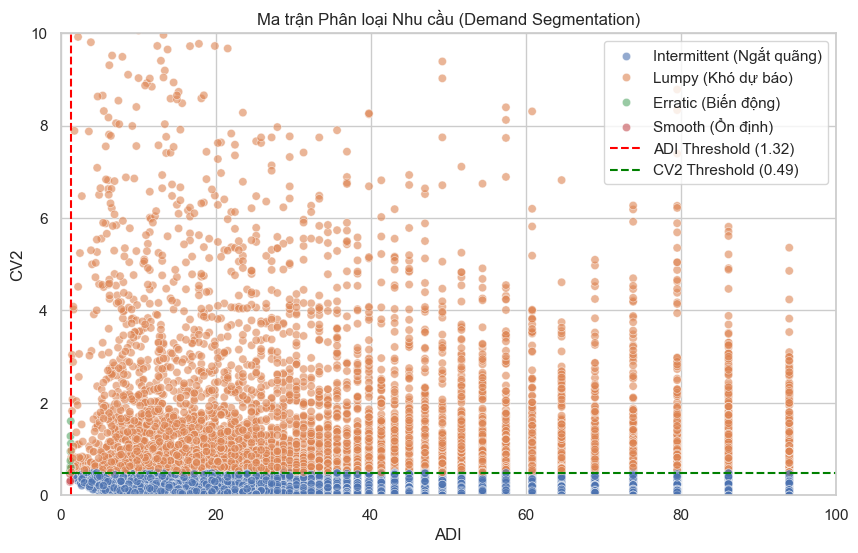

In [3]:
# 1. BƯỚC LỌC RÁC & NGOẠI LAI

print(">>> Kiểm tra ngoại lai (Outliers)...")

# Vẽ Boxplot để xem trước khi lọc
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=sales['item_cnt_day'], ax=ax[0], color='skyblue')
ax[0].set_title('Trước khi lọc: Số lượng bán')
sns.boxplot(x=sales['item_price'], ax=ax[1], color='orange')
ax[1].set_title('Trước khi lọc: Giá sản phẩm')
plt.show()

# Lọc bỏ ngoại lai
print(f"Kích thước dữ liệu gốc: {sales.shape}")
sales = sales[sales.item_price < 100000] # Bỏ giá quá cao
sales = sales[sales.item_cnt_day < 1001] # Bỏ số lượng quá lớn
sales = sales[sales.item_price > 0]      # Bỏ giá âm
print(f"Kích thước sau khi lọc: {sales.shape}")

# CẬP NHẬT LẠI DATAFRAME CHÍNH
# Biến df bây giờ sẽ chứa dữ liệu sạch
df = sales.merge(items, on='item_id', how='left').merge(cats, on='item_category_id', how='left')
print(">>> Đã xử lý xong ngoại lai. Bắt đầu phân loại...")

# 2. BƯỚC PHÂN LOẠI NHU CẦU

def calculate_adi_cv2(df_input):
    print("--- Đang tính toán ADI và CV²... ---")
    
    df_clean = df_input[df_input['item_cnt_day'] > 0].copy()
    total_days = (df_clean['date'].max() - df_clean['date'].min()).days + 1
    
    # Tính ADI
    demand_periods = df_clean.groupby(['shop_id', 'item_id'])['date'].nunique().reset_index(name='n_active_days')
    demand_periods['ADI'] = total_days / demand_periods['n_active_days']
    
    # Tính CV²
    daily_demand = df_clean.groupby(['shop_id', 'item_id', 'date'])['item_cnt_day'].sum().reset_index(name='qty')
    stats = daily_demand.groupby(['shop_id', 'item_id'])['qty'].agg(['mean', 'std']).reset_index()
    stats['std'] = stats['std'].fillna(0)
    
    stats['CV'] = stats['std'] / stats['mean']
    stats['CV2'] = stats['CV'] ** 2
    
    result = pd.merge(demand_periods, stats[['shop_id', 'item_id', 'CV2']], on=['shop_id', 'item_id'])
    return result

# Chạy hàm tính toán (Lúc này df đã sạch nhờ bước 1 ở trên)
segmentation_df = calculate_adi_cv2(df)

# Phân loại
def classify_product(row):
    if row['ADI'] < 1.32 and row['CV2'] < 0.49:
        return 'Smooth (Ổn định)'
    elif row['ADI'] >= 1.32 and row['CV2'] < 0.49:
        return 'Intermittent (Ngắt quãng)'
    elif row['ADI'] < 1.32 and row['CV2'] >= 0.49:
        return 'Erratic (Biến động)'
    else:
        return 'Lumpy (Khó dự báo)'

segmentation_df['Category_Type'] = segmentation_df.apply(classify_product, axis=1)

print("\n--- KẾT QUẢ PHÂN LOẠI (TRÊN DỮ LIỆU SẠCH) ---")
print(segmentation_df['Category_Type'].value_counts())

# Trực quan hóa
plt.figure(figsize=(10, 6))
sns.scatterplot(data=segmentation_df, x='ADI', y='CV2', hue='Category_Type', alpha=0.6, palette='deep')
plt.axvline(x=1.32, color='red', linestyle='--', label='ADI Threshold (1.32)')
plt.axhline(y=0.49, color='green', linestyle='--', label='CV2 Threshold (0.49)')
plt.title('Ma trận Phân loại Nhu cầu (Demand Segmentation)')
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.legend()
plt.show()

--- 1. Đang tạo khung dữ liệu theo tháng... ---
--- 2. Đang tạo đặc trưng độ trễ (Lags)... ---
--- 3. Đang tạo cột 'month' (Tháng)... ---
=> Đã tạo xong biến 'data_matrix'.
>>> Vẽ biểu đồ tương quan...


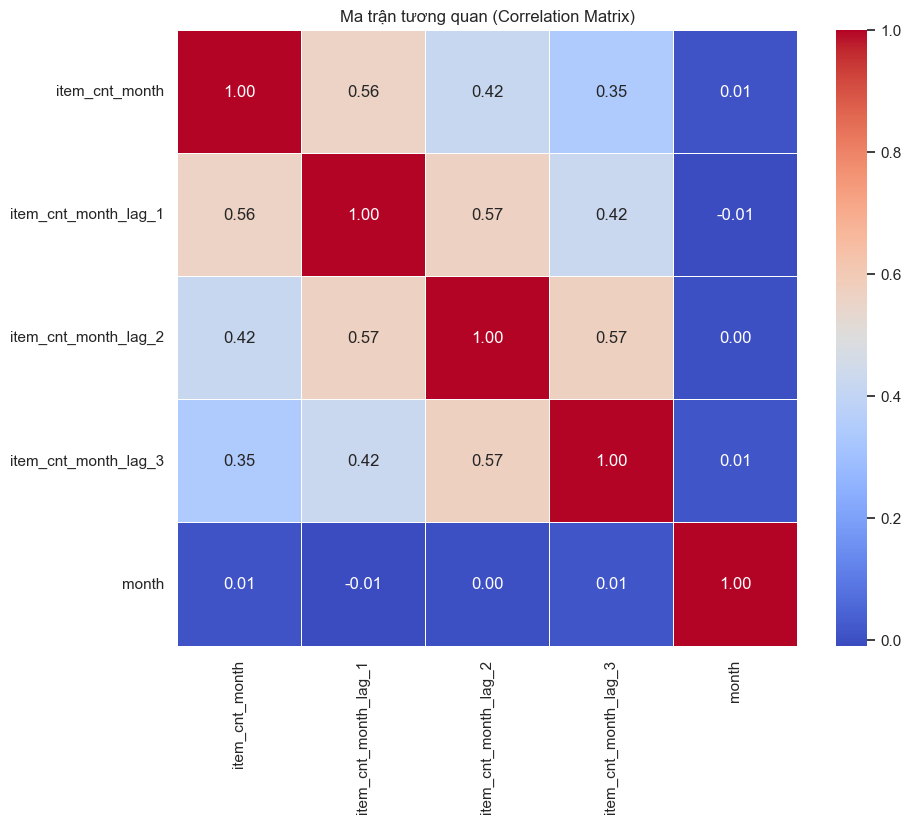

Nhận xét: Màu càng đậm chứng tỏ mối quan hệ càng chặt chẽ.


In [4]:
# --- TẠO DỮ LIỆU ---
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hàm tạo khung dữ liệu
def create_monthly_matrix(sales_df):
    print("--- 1. Đang tạo khung dữ liệu theo tháng... ---")
    matrix = []
    cols = ['date_block_num', 'shop_id', 'item_id']
    for i in sales_df['date_block_num'].unique():
        sales_month = sales_df[sales_df['date_block_num'] == i]
        matrix.append(np.array(list(product([i], sales_month.shop_id.unique(), sales_month.item_id.unique())), dtype='int16'))
    
    matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
    matrix.sort_values(cols, inplace=True)
    
    group = sales_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
    group.columns = ['item_cnt_month']
    group.reset_index(inplace=True)
    
    matrix = pd.merge(matrix, group, on=cols, how='left')
    matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16))
    return matrix

# 2. Thực thi tạo dữ liệu
if 'sales' not in locals():
    print("LỖI: Bạn cần chạy Khối 1 (Đọc dữ liệu) trước!")
else:
    data_matrix = create_monthly_matrix(sales)

    # --- TẠO LAG FEATURES ---
    print("--- 2. Đang tạo đặc trưng độ trễ (Lags)... ---")
    def lag_feature(df, lags, col):
        tmp = df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ['date_block_num','shop_id','item_id', f'{col}_lag_{i}']
            shifted['date_block_num'] += i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        return df

    data_matrix = lag_feature(data_matrix, [1, 2, 3], 'item_cnt_month')

    # --- TẠO CỘT MONTH ---
    print("--- 3. Đang tạo cột 'month' (Tháng)... ---")
    data_matrix['month'] = data_matrix['date_block_num'] % 12
    
    # Điền giá trị 0 cho các ô trống
    data_matrix = data_matrix.fillna(0)
    
    print("=> Đã tạo xong biến 'data_matrix'.")

    # --- MA TRẬN TƯƠNG QUAN (CORRELATION HEATMAP) ---
    print(">>> Vẽ biểu đồ tương quan...")

    # Chọn các cột quan trọng
    features_to_check = [
        'item_cnt_month',        # Target
        'item_cnt_month_lag_1',  # 1 tháng trước
        'item_cnt_month_lag_2',  # 2 tháng trước
        'item_cnt_month_lag_3',  # 3 tháng trước
        'month'                  # Tháng (Bây giờ đã có cột này)
    ]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 8))
    corr_data = data_matrix[features_to_check] # Không cần dropna vì đã fillna(0) ở trên
    correlation = corr_data.corr()

    sns.heatmap(
        correlation, 
        annot=True, 
        cmap='coolwarm', 
        fmt=".2f", 
        linewidths=0.5
    )
    plt.title('Ma trận tương quan (Correlation Matrix)')
    plt.show()

    print("Nhận xét: Màu càng đậm chứng tỏ mối quan hệ càng chặt chẽ.")

In [ ]:
# --- HUẤN LUYỆN MÔ HÌNH ---

from xgboost import XGBRegressor, plot_importance

# Kiểm tra dữ liệu
if 'data_matrix' not in locals():
    print("LỖI: Vui lòng chạy lại Khối 4 để tạo dữ liệu trước!")
else:
    print("--- Đang chia dữ liệu Train/Test... ---")
    X_train = data_matrix[data_matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
    Y_train = data_matrix[data_matrix.date_block_num < 33]['item_cnt_month']
    X_valid = data_matrix[data_matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
    Y_valid = data_matrix[data_matrix.date_block_num == 33]['item_cnt_month']

    print("--- Bắt đầu Training... ---")
    
    # Cấu hình cho phiên bản XGBoost mới
    model = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42,
        n_jobs=-1,
        eval_metric="rmse",       # <-- Đã chuyển vào đây
        early_stopping_rounds=10  # <-- Đã chuyển vào đây luôn
    )

    # Hàm fit() giờ chỉ cần truyền dữ liệu
    model.fit(
        X_train, 
        Y_train, 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=10
    )
    
    print("--- Huấn luyện thành công! ---")

In [ ]:
# --- ĐÁNH GIÁ MÔ HÌNH & KẾT LUẬN ---

# 1. Dự báo trên tập Validation
Y_pred = model.predict(X_valid).clip(0, 20)

# 2. Trực quan hóa Tầm quan trọng của các đặc trưng (Feature Importance)
# Biểu đồ này sẽ cho bạn biết yếu tố nào ảnh hưởng nhất đến doanh số (vd: Doanh số tháng trước?)
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, title='Top 10 Yếu tố quan trọng nhất (Feature Importance)')
plt.show()

print("""
--- KẾT LUẬN & KIẾN NGHỊ ---
1. Nếu 'item_cnt_month_lag_1' (doanh số tháng trước) nằm ở top đầu biểu đồ trên: 
   -> Nghĩa là xu hướng ngắn hạn cực kỳ quan trọng. Bán tốt tháng trước thì tháng này khả năng cao vẫn tốt.
2. Dựa vào nhóm phân loại (ADI/CV2) ở bước trước:
   -> Bạn có thể lọc riêng nhóm 'Erratic' (Biến động) để train một model riêng, vì nhóm này khó dự báo nhất.
3. Cải thiện:
   -> Có thể thêm thông tin về 'Giá sản phẩm' (Price trends) hoặc 'Ngày lễ tết' vào làm features để tăng độ chính xác.
""")

In [ ]:
# ---  BỔ SUNG ĐẶC TRƯNG 'THÁNG' & HUẤN LUYỆN ---

from xgboost import XGBRegressor, plot_importance

# 1. Tạo đặc trưng 'Tháng' (Feature Engineering)
print("--- 1. Đang thêm cột 'month'... ---")
if 'data_matrix' in locals():
    data_matrix['month'] = data_matrix['date_block_num'] % 12
else:
    print("Lỗi: Biến 'data_matrix' chưa tồn tại. Hãy chạy Khối 4 trước!")

# 2. Chia lại dữ liệu Train/Validation (với cột month mới)
print("--- 2. Chia lại dữ liệu Train/Test... ---")
X_train = data_matrix[data_matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data_matrix[data_matrix.date_block_num < 33]['item_cnt_month']
X_valid = data_matrix[data_matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data_matrix[data_matrix.date_block_num == 33]['item_cnt_month']

# 3. Huấn luyện lại mô hình (Cú pháp mới đã sửa lỗi)
print("--- 3. Bắt đầu Retraining với dữ liệu mới... ---")

# Khởi tạo mô hình với tham số eval_metric ở đây
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
    n_jobs=-1,
    eval_metric="rmse",         # <-- Đã chuyển lên đây
    early_stopping_rounds=10    # <-- Đã chuyển lên đây
)

# Hàm fit() chỉ cần truyền dữ liệu
model.fit(
    X_train, 
    Y_train, 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=10
)

print("--- Huấn luyện lại hoàn tất! ---")

# 4. Xem lại Feature Importance (Để xem 'month' có quan trọng không)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, title='Top 10 Yếu tố quan trọng (Sau khi thêm Month)')
plt.show()

In [13]:
# --- SO SÁNH MÔ HÌNH (MODEL COMPARISON) ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Bắt đầu so sánh các thuật toán... ---")
models_result = {}

# 1. Lấy kết quả từ XGBoost (Đã chạy ở Khối 7)
# Chúng ta dùng lại model vừa train xong để dự báo
if 'model' in locals():
    y_pred_xgb = model.predict(X_valid).clip(0, 20)
    xgb_rmse = np.sqrt(mean_squared_error(Y_valid, y_pred_xgb))
    models_result['XGBoost'] = xgb_rmse
    print(f"1. XGBoost RMSE: {xgb_rmse:.4f}")
else:
    print("Lỗi: Chưa có model XGBoost. Hãy chạy Khối 7 trước.")

# 2. Chạy Linear Regression (Mô hình cơ bản nhất)
print("--- 2. Đang chạy Linear Regression (Hồi quy tuyến tính)... ---")
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
y_pred_lr = lr_model.predict(X_valid).clip(0, 20)
lr_rmse = np.sqrt(mean_squared_error(Y_valid, y_pred_lr))
models_result['Linear Regression'] = lr_rmse
print(f"-> Linear Regression RMSE: {lr_rmse:.4f}")

# 3. Chạy Random Forest (Mô hình mạnh, nhưng chậm)
print("--- 3. Đang chạy Random Forest (Chạy mẫu 20% dữ liệu để nhanh)... ---")
# Lấy mẫu ngẫu nhiên 20% dữ liệu để train nhanh (vì Random Forest tốn RAM)
sample_size = int(len(X_train) * 0.2)
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_train_sample = X_train.iloc[indices]
Y_train_sample = Y_train.iloc[indices]

rf_model = RandomForestRegressor(n_estimators=20, max_depth=8, random_state=42, n_jobs=-1)
rf_model.fit(X_train_sample, Y_train_sample)
y_pred_rf = rf_model.predict(X_valid).clip(0, 20)
rf_rmse = np.sqrt(mean_squared_error(Y_valid, y_pred_rf))
models_result['Random Forest'] = rf_rmse
print(f"-> Random Forest RMSE: {rf_rmse:.4f}")

# --- TRỰC QUAN HÓA KẾT QUẢ SO SÁNH ---
plt.figure(figsize=(8, 5))
# Vẽ biểu đồ cột so sánh RMSE (Càng thấp càng tốt)
ax = sns.barplot(x=list(models_result.keys()), y=list(models_result.values()), palette='viridis')
plt.title('So sánh sai số RMSE giữa các mô hình (Thấp hơn là tốt hơn)')
plt.ylabel('RMSE Score')
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')
plt.show()

--- Bắt đầu so sánh các thuật toán... ---
Lỗi: Chưa có model XGBoost. Hãy chạy Khối 7 trước.
--- 2. Đang chạy Linear Regression (Hồi quy tuyến tính)... ---


NameError: name 'X_train' is not defined

--- Bắt đầu phân cụm các Cửa hàng (Shop Clustering)... ---


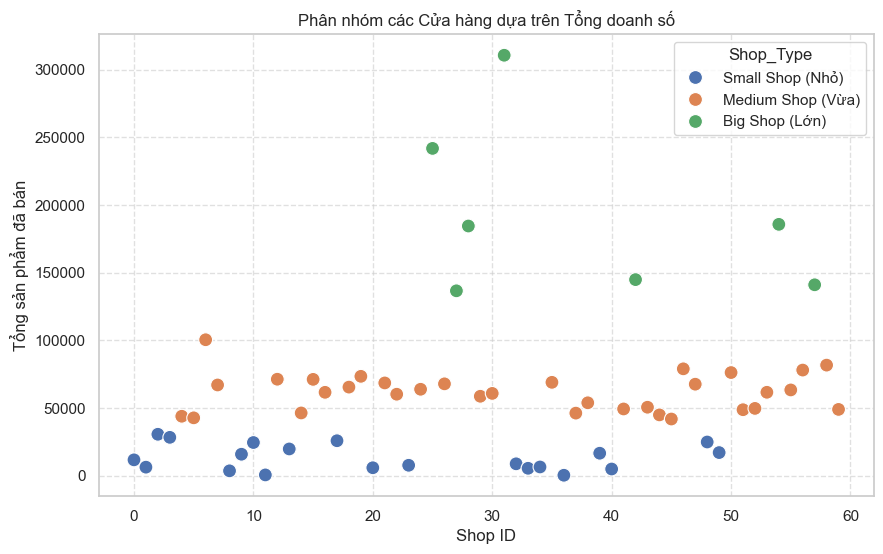

--- Kết quả phân cụm: ---
Shop_Type
Medium Shop (Vừa)    33
Small Shop (Nhỏ)     20
Big Shop (Lớn)        7
Name: count, dtype: int64


In [14]:
# --- PHÂN CỤM CỬA HÀNG (CLUSTERING) ---
from sklearn.cluster import KMeans

print("--- Bắt đầu phân cụm các Cửa hàng (Shop Clustering)... ---")

# 1. Chuẩn bị dữ liệu: Tổng doanh số theo từng Shop
# Chúng ta muốn gom nhóm các shop bán chạy và shop bán ế
shop_sales = df.groupby('shop_id')['item_cnt_day'].sum().reset_index()
X_cluster = shop_sales[['item_cnt_day']]

# 2. Áp dụng K-Means để chia thành 3 nhóm
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
shop_sales['cluster'] = kmeans.fit_predict(X_cluster)

# 3. Đặt tên cho các nhóm (Dựa trên doanh số trung bình của nhóm)
# Nhóm nào có doanh số trung bình cao nhất -> "Big Shop"
cluster_avg = shop_sales.groupby('cluster')['item_cnt_day'].mean().sort_values()
cluster_mapping = {
    cluster_avg.index[0]: 'Small Shop (Nhỏ)',
    cluster_avg.index[1]: 'Medium Shop (Vừa)',
    cluster_avg.index[2]: 'Big Shop (Lớn)'
}
shop_sales['Shop_Type'] = shop_sales['cluster'].map(cluster_mapping)

# 4. Vẽ biểu đồ phân cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=shop_sales, 
    x='shop_id', 
    y='item_cnt_day', 
    hue='Shop_Type', 
    palette='deep', 
    s=100
)
plt.title('Phân nhóm các Cửa hàng dựa trên Tổng doanh số')
plt.xlabel('Shop ID')
plt.ylabel('Tổng sản phẩm đã bán')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("--- Kết quả phân cụm: ---")
print(shop_sales['Shop_Type'].value_counts())